# Logistic Regression on IRIS Dataset using the Scikit-learn library.

In [28]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

## Data Acquisition

In [3]:
# Import the iris dataset
iris = datasets.load_iris()
X = iris.data[:, :4]  # keep first four features.
y = iris.target

In [4]:
dataset_file = iris.filename
dataset_file

'iris.csv'

In [5]:
print(f"X {X.shape}")
print(f"y {len(y)}")

X (150, 4)
y 150


In [6]:
print(X[:5, :])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


## Feature Engineering

In [7]:
# split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [8]:
print(f"X_train {X_train.shape}")
print(f"X_test {X_test.shape}")
print(f"y_train {len(y_train)}")
print(f"y_test {len(y_test)}")

X_train (112, 4)
X_test (38, 4)
y_train 112
y_test 38


## Training

In [9]:
# normalize data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
print(X_train[:5, :])

[[ 0.01543995 -0.11925475  0.22512685  0.35579762]
 [-0.09984503 -1.04039491  0.11355956 -0.02984109]
 [ 1.05300481 -0.11925475  0.95031423  1.12707506]
 [-1.36797986  0.34131533 -1.39259884 -1.31530348]
 [ 1.1682898   0.11103029  0.72717965  1.38416753]]


## Evaluation

In [11]:
# Fit Logistic Regression 
from sklearn.linear_model import LogisticRegression
solver = 'lbfgs'
classifier = LogisticRegression(random_state = 0, solver=solver, multi_class='auto')
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [12]:
# Predict using test set
y_pred = classifier.predict(X_test)

# Predict probabilities using test set
probs_y = classifier.predict_proba(X_test)
probs_y_rounded = np.round(probs_y, 2)

In [13]:
res = "{:<10} | {:<10} | {:<10} | {:<13} | {:<5}".format("y_test", "y_pred", "Setosa(%)", "versicolor(%)", "virginica(%)\n")
res += "-"*65+"\n"
res += "\n".join("{:<10} | {:<10} | {:<10} | {:<13} | {:<10}".format(x, y, a, b, c) for x, y, a, b, c in zip(y_test, y_pred, probs_y_rounded[:,0], probs_y_rounded[:,1], probs_y_rounded[:,2]))
res += "\n"+"-"*65+"\n"
print(res)

y_test     | y_pred     | Setosa(%)  | versicolor(%) | virginica(%)
-----------------------------------------------------------------
2          | 2          | 0.0        | 0.03          | 0.97      
1          | 1          | 0.01       | 0.95          | 0.04      
0          | 0          | 1.0        | 0.0           | 0.0       
2          | 2          | 0.0        | 0.08          | 0.92      
0          | 0          | 0.98       | 0.02          | 0.0       
2          | 2          | 0.0        | 0.01          | 0.99      
0          | 0          | 0.98       | 0.02          | 0.0       
1          | 1          | 0.01       | 0.71          | 0.28      
1          | 1          | 0.0        | 0.73          | 0.27      
1          | 1          | 0.02       | 0.89          | 0.08      
2          | 2          | 0.0        | 0.44          | 0.56      
1          | 1          | 0.02       | 0.76          | 0.22      
1          | 1          | 0.01       | 0.85          | 0.13      
1       

In [14]:
accuracy = classifier.score(X_test, y_pred)

In [15]:
print(f"accuracy {accuracy}")

accuracy 1.0


In [16]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


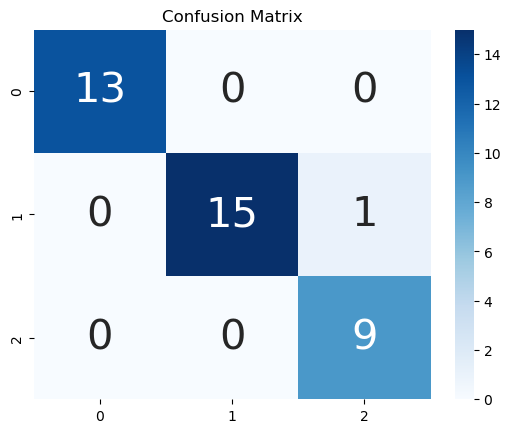

In [35]:
# Plot confusion matrix
import seaborn as sns
import pandas as pd
import os

# confusion matrix sns heatmap 
fig = plt.figure()

ax = plt.axes()
df_cm = cm
sns.heatmap(df_cm, annot=True, annot_kws={"size": 30}, fmt='d',cmap="Blues", ax = ax )
ax.set_title('Confusion Matrix')
plt.show()

output_folder="generated"
os.makedirs(output_folder, exist_ok=True)
fig.savefig(os.path.join(output_folder, 'cm.png'))

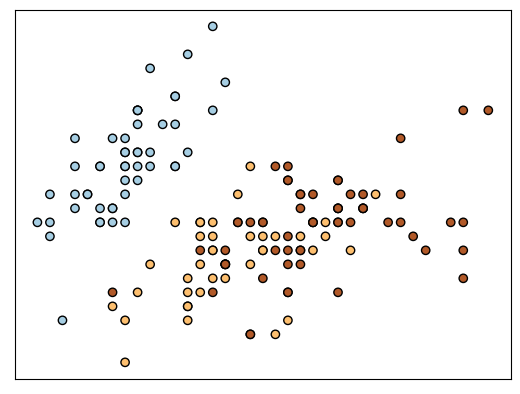

In [21]:
# Plot the dataset points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)


plt.xticks(())
plt.yticks(())

plt.show()

## Experiment Tracking

In [6]:
! pip install 'sagemaker-experiments==0.1.42'  # noqa

TODO requires a job or training job

In [31]:
from smexperiments import experiment, tracker
import uuid

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()

try:
    my_experiment = experiment.Experiment.create(experiment_name='iris-LR')
except:
    my_experiment =experiment.Experiment.load(experiment_name='iris-LR')

tid = uuid.uuid1()
print(tid)
my_trial = my_experiment.create_trial(trial_name=f'LR-{tid}')

# use `with` statement to ensure `my_tracker.close()` is called
with tracker.Tracker.create(display_name="Training") as my_tracker:
    # log hyper parameter of learning rate
    my_tracker.log_parameter('solver', solver)
    # log dataset
    my_tracker.log_input(name='input', value=dataset_file)
    # log hyper metric of learning rate
    my_tracker.log_metric('accuracy', accuracy)
    my_tracker.log_metric(metric_name='accuracy', value=accuracy, iteration_number=1)

    # log a table
    #my_tracker.log_table('Confusion Matrix', cm)

    # log a figure
    my_tracker.log_artifact('cm.png', name='confusion-matrix-plot')
                            
    # associate the trial component with the trial
    my_trial.add_trial_component(my_tracker)

02e0c366-848e-11ed-9c0a-1f9491087f11


# required packages

In [5]:
! pip list  # noqa

Package                              Version
------------------------------------ --------------------
alabaster                            0.7.12
anaconda-client                      1.11.0
anaconda-project                     0.11.1
anyio                                3.5.0
appdirs                              1.4.4
argon2-cffi                          21.3.0
argon2-cffi-bindings                 21.2.0
arrow                                1.2.2
astroid                              2.11.7
astropy                              5.1
asttokens                            2.2.1
atomicwrites                         1.4.0
attrs                                21.4.0
Automat                              20.2.0
autopep8                             1.6.0
autovizwidget                        0.20.0
awscli                               1.27.24
Babel                                2.9.1
backcall                             0.2.0
backports.functools-lru-cache        1.6.4
backports.tempfile          